In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandahouse as ph

from scipy import stats as ss
from scipy.stats import norm
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

#  A/B тест

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Загрузка данных и разведовательный анализ**

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [2]:
url = 'https://drive.google.com/file/d/1tulVhm54b7qjTDHCTP84laEBuJNdlFnJ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

In [5]:
df_groups = pd.read_csv(path, sep=';')

In [6]:
df_groups.head()

id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A

In [7]:
# Размер данных
df_groups.shape

(74484, 2)

In [8]:
# Типы данных
df_groups.dtypes

id      int64
grp    object
dtype: object

In [9]:
# Проверка на пустые значения
df_groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
# Для дальнейшего джоина таблиц, переиминуем колонку
df_groups = df_groups.rename(columns={'id': 'student_id'})

Дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных

In [11]:
url_1 = 'https://dhttps://drive.google.com/file/d/1jLqsHkxweU3-7tFxBwymV_bPut2ZDlKo/view?usp=sharing'
path_1 = 'https://drive.google.com/uc?export=download&id='+url_1.split('/')[-2]

In [12]:
df_groups_add = pd.read_csv(path_1)

In [13]:
df_groups_add.head()

id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B

In [14]:
# Размер данных
df_groups_add.shape

(92, 2)

In [15]:
# Типы данных
df_groups_add.dtypes

id      int64
grp    object
dtype: object

In [16]:
# Проверка на пустые значения
df_groups_add.isna().sum()

id     0
grp    0
dtype: int64

Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [17]:
df_active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')

In [18]:
df_active_studs.head()

student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369

In [19]:
# Размер данных
df_active_studs.shape

(8341, 1)

In [20]:
# Типы данных
df_active_studs.dtypes

student_id    int64
dtype: object

In [21]:
# Проверка на пустые значения
df_active_studs.isna().sum()

student_id    0
dtype: int64

Файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [22]:
url_2 = 'https://drive.google.com/file/d/1G3c8L-b6sjKePDxjgMmFAIrhBoBxvIND/view?usp=sharing'
path_2 = 'https://drive.google.com/uc?export=download&id='+url_2.split('/')[-2]

In [23]:
df_checks = pd.read_csv(path_2, sep=';')

In [24]:
df_checks.head()

student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0

In [25]:
# Размер данных
df_checks.shape

(541, 2)

In [26]:
# Типы данных
df_checks.dtypes

student_id      int64
rev           float64
dtype: object

In [27]:
# Проверка на пустые значения
df_checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [28]:
df_checks.describe()

student_id          rev
count  5.410000e+02   541.000000
mean   2.514772e+06  1059.752317
std    1.726839e+06   762.712359
min    1.627000e+03   199.000000
25%    9.871290e+05   290.000000
50%    2.526021e+06   840.000000
75%    3.993249e+06  1900.000000
max    5.740903e+06  4650.000000

**Мердж необходимого DF**

In [29]:
df_exp = df_groups.merge(df_active_studs, how='right', on='student_id')

In [30]:
df_exp.head()

student_id  grp
0      581585    A
1     5723133  NaN
2     3276743    B
3     4238589    A
4     4475369    B

In [31]:
df_exp.isna().sum()

student_id     0
grp           13
dtype: int64

Не все id пришедшие на сайт в дни эксперимента участвовали в нём

In [32]:
# дроп id не вошедших ни в одну из групп
df_exp = df_exp.dropna(subset=['student_id', 'grp'])

In [33]:
df_exp.isna().sum()

student_id    0
grp           0
dtype: int64

In [34]:
df_exp.shape

(8328, 2)

In [35]:
# Добавим данные об оплатах
df_exp = df_exp.merge(df_checks, how='outer', on='student_id')

In [36]:
df_exp.head()

student_id grp  rev
0      581585   A  NaN
1     3276743   B  NaN
2     4238589   A  NaN
3     4475369   B  NaN
4     5481015   B  NaN

In [37]:
df_exp.isna().sum()

student_id       0
grp            150
rev           7937
dtype: int64

In [38]:
df_exp.shape

(8478, 3)

In [39]:
df_exp.student_id.nunique()

8478

**7937 пользователей не совершили никаких платежных действий. <br/> Так же 150 пользователей не были причислены ни к одной из групп, либо они совершили оплату не заходя на сайт (через сторонние формы), или по каким либо иным причинам не попали под распределение по группам. Пустые значения в оплате заменим нулями, а пользователей не попавших в группы исключим из итогового df.**

In [40]:
df_exp = df_exp.dropna(subset=['grp'])

In [41]:
# Заменим пустые значения на 0
df_exp = df_exp.fillna(0)

In [42]:
df_exp.isna().sum()

student_id    0
grp           0
rev           0
dtype: int64

In [43]:
df_exp.head()

student_id grp  rev
0      581585   A  0.0
1     3276743   B  0.0
2     4238589   A  0.0
3     4475369   B  0.0
4     5481015   B  0.0

In [44]:
# Количество пользователей в контрольной и тестовой группе
df_exp.value_counts('grp').sort_values()

grp
A    1535
B    6793
dtype: int64

Количество пользователей не равно, но размер выборок достаточен для проведения теста

**Графики и метрики**

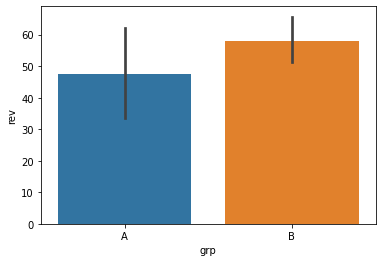

In [45]:
sns.barplot(data = df_exp, y = 'rev', x = 'grp')

Основываясь на имебщихся данных, в качестве метрики возьму средний чек (ARPU) и конверсию. Это позволит судить об эффективности новой механики.<br/> Например в новой механике оплаты - доп.услуги подбираются и позиционируются гораздо лучше, что может увеличить средний чек. 

In [46]:
# Средний чек контроля.
df_exp\
    .query('grp == "A"')\
    .agg({'rev': 'mean'})

rev    47.439739
dtype: float64

In [47]:
# Конверсия в контроле
(df_exp.query('grp == "A" and rev > 0').shape[0] / df_exp.query('grp == "A"').shape[0]) * 100

5.081433224755701

In [49]:
# Средний чек теста.
df_exp\
    .query('grp == "B"')\
    .agg({'rev': 'mean'})

rev    57.864567
dtype: float64

In [50]:
# Конверсия в тесте
(df_exp.query('grp == "B" and rev > 0').shape[0] / df_exp.query('grp == "B"').shape[0]) * 100

4.607684380980421

На глаз различия есть. В тестовой группе средний чек больше (даже если сделать условие rev != 0), а вот конверсия меньше чем в контрольной.

**Распределения и выбросы**

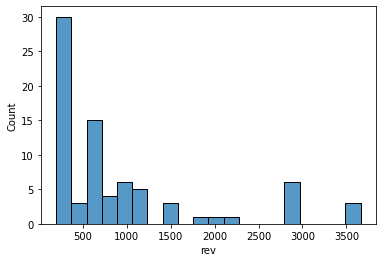

In [52]:
df_exp_control_hist = df_exp.query('grp == "A" and rev > 0') # уберем нули что бы увидеть распределение самих оплат
sns.histplot(data = df_exp_control_hist.rev, bins = 20)

Преобразование данных с помощью логарифмирования данных с нулями невозможно

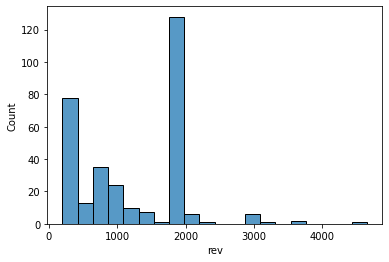

In [53]:
df_exp_test_hist = df_exp.query('grp == "B" and rev > 0')
sns.histplot(data = df_exp_test_hist.rev, bins = 20)

In [54]:
df_exp_test_hist.query('rev > 1800 and rev < 2000').shape[0]

130

In [58]:
df_exp_test_hist.rev.value_counts().head()

1900.0000    92
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

В группе **B** есть странный выброс со 127 пользователями заплатившими практически одну и ту же сумму. Понять что это без дополнительных данных сложно. Может это какая то услуга которая в новой платежке очень хорошо позиционированна и поэтому так хорошо продается.

Распределения данных ненормальны и очень разбросанны. преобразование данных с помощью логрифма не помогло. Нужно либо ипользовать подходящую непарометрику, либо бустрап.

# **A/B тесты** 

<br/>
Так как выборки неравномерны, а распделения ненормальны, то для ARPU нужно использовать бутстрап.<br/> Т-тест не подойдет из-за неравномерности выборок.<br/> Манна-Уитни это стохастический тест (стохастическое доминирование одной выборки над другой, насколько чаще в одной выборке встречаются более высокие значения, чем в другой), но стоит помнить что выборки у нас неравномерные и мы хотим посмотреть на различия именно по среднему чеку. <br/><br/>Для теста среднего используем бустрап.

H0 - различий в среднем чеке нет<br/>
H1 - различия в среднем чеке есть

Создадим вектора:

In [ ]:
df_exp_control = df_exp.query('grp == "A"')

In [ ]:
df_exp_test = df_exp.query('grp == "B"')

**Бутстрап тест**

In [99]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика (по умолчанию mean)
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

**Бутсрап тест для среднего чека.**

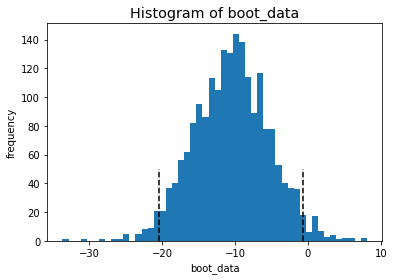

In [83]:
df_booted_mean = get_bootstrap(df_exp_control.rev, df_exp_test.rev, boot_it = 2000)

In [84]:
df_booted_mean["p_value"]

0.04153115037156903

Статзначимое различие по среднему чеку зафиксированно **H1**

Так как группа у нас - это категориальная переменная , то для теста конверсии буду использовать критерий хи-квадрат для проверки на независимость группы с оплатой. То есть, есть ли звязь между тестовой или контрольной группой с итоговой конверсией. <br/><br/>
H0 - связи между группой и оплатой нет<br/>
H1 - связь между группой и оплатой есть

Для проведения теста через Хи-квадрат, нужно создать таблицу сопряженности. Таблица будет разбита на две группы с двумя столбцами - заплатившие пользователи и сколько пользователей в группе всего

In [170]:
group_a_pay_count = df_exp.query('rev != 0 and grp == "A"').rev.count()
group_a_pay_count

78

In [171]:
group_a_count = df_exp.query('grp == "A"').rev.count()
group_a_count

1535

In [172]:
group_b_pay_count = df_exp.query('rev != 0 and grp == "B"').rev.count()
group_b_pay_count

313

In [173]:
group_b_count = df_exp.query('grp == "B"').rev.count()
group_b_count

6793

In [192]:
# Создаем итоговую таблицу
df_chi_exp = pd.DataFrame({'a':[group_a_pay_count, group_a_count],'b':[group_b_pay_count, group_b_count]})

In [189]:
df_chi_exp

a     b
0    78   313
1  1535  6793

In [196]:
tstat, p_value, dof, expected = ss.chi2_contingency(df_chi_exp)

In [197]:
tstat

0.47388913808402716

In [191]:
p_value

0.4912034030799808

**H0** - зависимости нет

# Вывод

По результатам проведенных A/B тестов можно уверенно говорить о том что новая механика оплаты увеличивает средний чек по сумме оплаты, а отрицательная конверсия в тестовой группе никак не связана с самой оплатой.<br/> **Для увелечения среднего чека новую механику оплаты можно раскатывать на всех пользователей.**

# 2.1 SQL

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [6]:
# создаем запрос
q = '''
SELECT 
    COUNT(st_id)
FROM
    (SELECT  
        st_id,
        SUM(correct) AS sum_corr
    FROM
        default.peas
    GROUP BY 
        st_id
    HAVING 
        sum_corr >= 20) 
    '''

# отправляем запрос и записываем результат датафрейм
sql_df_1 = ph.read_clickhouse(query=q, connection=connection_default)
sql_df_1.head()

count(st_id)
0           136

**136 уникальных** пользователей завершивших правильно 20 заданий в течении месяца (в таблице данные всего за два дня)

# 2.2 SQL

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU (средний чек на всех АКТИВНЫХ пользователей)
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

In [7]:
sql_2 = '''
SELECT 
    studs.test_grp,
    ROUND(SUM(sum_money) / COUNTDISTINCT(studs.st_id), 2) AS ARPU,
    ROUND(sumIf(sum_money, sum_corr > 10) / uniqIf(studs.st_id, sum_corr > 10), 2) AS ARPAU,
    ROUND(countIf(studs.st_id, sum_money > 0) / COUNT(studs.st_id) * 100, 2) AS CR,
    ROUND(countIf(studs.st_id, sum_corr > 10 AND sum_money > 0) / countIf(studs.st_id, sum_corr > 10) * 100, 2) AS active_CR,
    ROUND(countIf(studs.st_id, cr_active_math_cor > 0 AND sum_math > 0) / countIf(studs.st_id, cr_active_math_cor > 1) * 100, 2) AS active_math_CR
    
FROM
    default.studs AS studs

LEFT JOIN
    (SELECT
        st_id,
        SUM(money) AS sum_money,
        SUM(CASE
            WHEN subject = 'Math' 
            THEN money 
            ELSE 0 
            END) AS sum_math
    FROM
        default.final_project_check
    GROUP BY
        st_id) AS checks
ON studs.st_id = checks.st_id

LEFT JOIN
    (SELECT
        st_id,
        SUM(correct) AS sum_corr,
        SUM(CASE
            WHEN subject = 'Math' 
            THEN correct 
            ELSE 0 
            END) AS cr_active_math_cor
    FROM
        default.peas
    GROUP BY 
        st_id) AS peas
ON studs.st_id = peas.st_id

GROUP BY
    test_grp 
    '''

# отправляем запрос и записываем результат в датафрейм
sql_df_2 = ph.read_clickhouse(query=sql_2, connection=connection_default)
sql_df_2.head()

studs.test_grp      ARPU     ARPAU     CR  active_CR  active_math_CR
0        control   4540.98  10393.70   4.92      11.02            6.12
1          pilot  11508.47  29739.58  10.85      26.04            9.52

# Python

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [51]:
url = 'https://drive.google.com/file/d/1tulVhm54b7qjTDHCTP84laEBuJNdlFnJ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
url_1 = 'https://dhttps://drive.google.com/file/d/1jLqsHkxweU3-7tFxBwymV_bPut2ZDlKo/view?usp=sharing'
path_1 = 'https://drive.google.com/uc?export=download&id='+url_1.split('/')[-2]
url_2 = 'https://drive.google.com/file/d/1G3c8L-b6sjKePDxjgMmFAIrhBoBxvIND/view?usp=sharing'
path_2 = 'https://drive.google.com/uc?export=download&id='+url_2.split('/')[-2]
path_3 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg'

In [52]:
def groups_add(path_1, path_2, path_3, path_4):
    '''Функция добавляет доболнительные 
       id пользователей к основному df
       и выводит метрику ARPU и CR'''
    
    # Загрузка данных
    df_groups = pd.read_csv(path_1, sep=';')
    df_groups_add = pd.read_csv(path_2)
    df_checks = pd.read_csv(path_3, sep = ';')
    df_checks = df_checks.rename(columns={'student_id': 'id'})
    df_active_studs = pd.read_csv(path_4)
    df_active_studs = df_active_studs.rename(columns={'student_id': 'id'})
    
    # Джоин датафрейма
    df_groups = pd.concat([df_groups, df_groups_add], ignore_index=True)
    df_groups = df_groups.merge(df_active_studs, how='right', on = 'id')
    df_final = df_groups.merge(df_checks, how='left', on = 'id')
    # Замена NaN в rev нулями
    df_final = df_final.fillna(0)
    
    # средний чек группы A
    df_group_a_mean = df_final\
        .query('grp == "A"')\
        .rev.mean()
    # средний чек группы B
    df_group_b_mean = df_final\
        .query('grp == "B"')\
        .rev.mean()
    
    # Конверсия в группе A
    df_group_a_cr = (df_final.query('grp == "A" and rev > 0').shape[0] / df_final.query('grp == "A"').shape[0]) * 100
    # Конверсия в группе B
    df_group_b_cr = (df_final.query('grp == "B" and rev > 0').shape[0] / df_final.query('grp == "B"').shape[0]) * 100
    
    # Создаем итоговый df
    df_output = pd.DataFrame({'grp': ['A', 'B'], 'ARPU': [df_group_a_mean, df_group_b_mean], 
                              'CR':[df_group_a_cr, df_group_b_cr]})
    
    # вывод метрик
    return df_output
    

In [53]:
df_chart = groups_add(path, path_1, path_2, path_3)

In [54]:
df_chart

grp       ARPU        CR
0   A  47.347204  5.071521
1   B  58.058798  4.615611

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [67]:
def metrics_visual(df):
    '''Функция визуализирует метрики
       ARPU и CR получаемые из функции
       group_add()'''
    
    # Задание настроек графика
    sns.set(font_scale = 1, style="darkgrid")
    fig, axes = plt.subplots(2, figsize=(6, 10))
    
    # Рисуем график
    sns.barplot(ax=axes[0], data=df, x='grp', y='ARPU')
    sns.barplot(ax=axes[1], data=df, x='grp', y='CR')
    

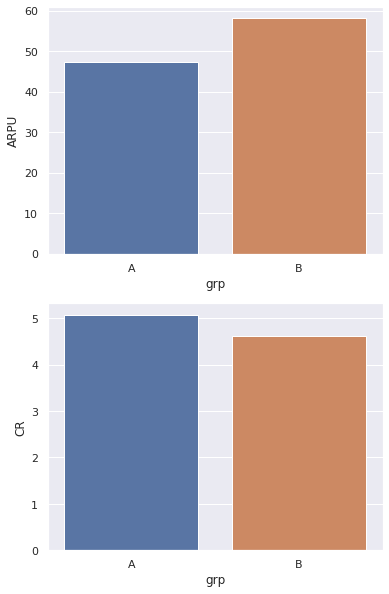

In [68]:
metrics_visual(df_chart)